In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import ClusterCentroids
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [40]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

treino = treino.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])
teste = teste.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])

In [41]:
numeric_feats = treino.dtypes[treino.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')
numeric_feats = numeric_feats.drop('situacao')

treino[numeric_feats] = np.log1p(treino[numeric_feats])

teste[numeric_feats] = np.log1p(teste[numeric_feats])

In [42]:
allData = pd.concat((teste,treino), sort=False)

teste = allData.loc[:,:'ocupacao']
teste = pd.get_dummies(teste)

treino_X = teste.loc[teste['ano'] != 2014]
teste = teste.loc[teste['ano'] == 2014]

treino_Y = allData.loc[allData['ano'] != 2014]
treino_Y = treino_Y.loc[:,'situacao']

In [43]:
treino_X = treino.loc[:,:'ocupacao']
treino_Y = treino.loc[:,'situacao']

In [44]:
treino_X = pd.get_dummies(treino_X)
teste = pd.get_dummies(teste)

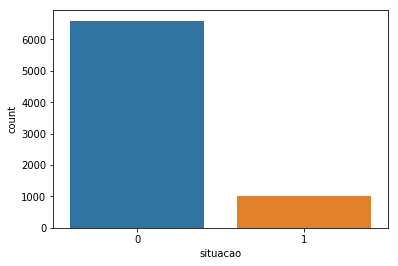

In [45]:
sns.countplot(treino_Y)

É clara a diferença entre a quantidade de instâncias da classe nao_eleito e eleito. Isso pode levar o modelo a aprender de forma errada a classificar os exemplos de teste.

Para balancear as classes usarei a técnica de under-sampling, cluser centroids.

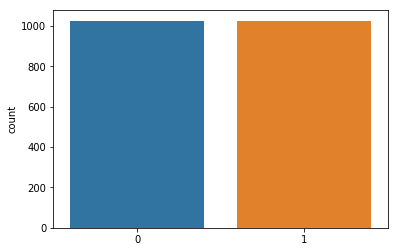

In [46]:
cc = ClusterCentroids()
x_cc, y_cc = cc.fit_sample(treino_X, treino_Y)
y_cc = y_cc[:,np.newaxis]

sns.countplot(y_cc[:,0])

Com a mesma quantidade de instâncias entre as duas classes, a chance de o modelo sofrer de unerfiting é bem menor.

A seguir inicio o treinamento de alguns modelos a partir dos dados filtrados.

In [47]:
data = np.concatenate((x_cc, y_cc), axis=1)
data = np.random.permutation(data)
x_cc = data[:,0:-1]
y_cc = data[:,-1]

In [48]:
treino_X = np.array(treino_X)
treino_Y = np.array(treino_Y)

Para melhorar a validação dos modelos, utilizo uma fação para fazer uma permutação aleatória nos dados, pois esses ficam agrupados na saída da função de cluster centroids.

In [68]:
def cv_report(model, predictors, outcome, nfolds):
    
    kf = KFold(n_splits=nfolds)
    f1_score = []
    for train, validation in kf.split(predictors):
        train_predictors = (predictors[train,:])
        train_target =  outcome[train]
        model.fit(train_predictors, train_target)
        
        y = model.predict(predictors[validation,:])
        report = metrics.classification_report(outcome[validation], y, output_dict=True)
        f1_score.append(report['micro avg']['f1-score'])
        
    return np.mean(f1_score)

In [82]:
def real_f1(model):
    return metrics.classification_report(treino_Y, model.predict(treino_X), output_dict=True)['micro avg']['f1-score']

## Regressão Logística

In [72]:
lambdas = np.arange(0.01,2,0.01).tolist()

In [15]:
cv_logRegUnbalanced = [cv_report(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), treino_X, treino_Y, 5).mean()
            for lbd in lambdas]
cv_logRegUnbalanced = pd.Series(cv_logRegUnbalanced, index = lambdas)

NameError: name 'cv_logRegression' is not defined

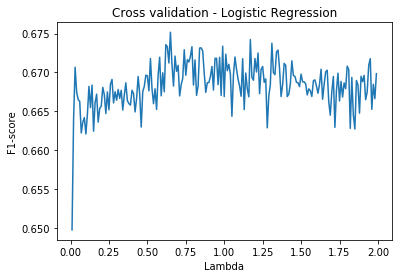

O melhor alpha é 0.65, com F1 = 0.67516386896603


In [16]:
cv_logRegUnbalanced.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(fullcv_logRegUnbalanced.idxmax(), fullcv_logRegUnbalanced.max()))

In [73]:
cv_logRegBalanced = [cv_report(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), x_cc, y_cc, 5).mean()
            for lbd in lambdas]
cv_logRegBalanced = pd.Series(cv_logRegBalanced, index = lambdas)

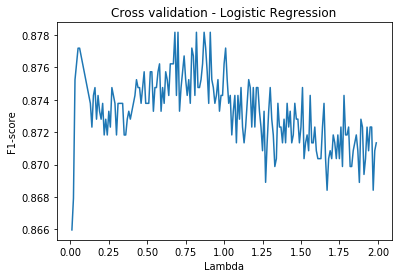

O melhor alpha é 0.7000000000000001, com F1 = 0.8781627203133345


In [74]:
cv_logRegBalanced.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegBalanced.idxmax(), cv_logRegBalanced.max()))

In [84]:
lgModel = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegBalanced.idxmax(), random_state=1)
lgModel.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(lgModel)))

O F1 do modelo para todos os dados é 0.9025190238782472


## KNN

In [76]:
k_list = np.arange(1,100,1).tolist()

In [57]:
cv_knnUnbalanced = [cv_report(KNeighborsClassifier(n_neighbors = n), treino_X, treino_Y, 5).mean()
            for n in k_list]

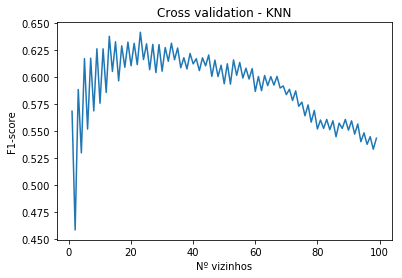

O melhor lambda é 23, com F1-score = 0.6416932630127661


In [58]:
cv_knnUnbalanced = pd.Series(cv_knnUnbalanced, index = k_list)
cv_knnUnbalanced.plot(title = "Cross validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnUnbalanced.idxmax(), cv_knnUnbalanced.max()))

In [77]:
cv_knnBalanced = [cv_report(KNeighborsClassifier(n_neighbors = n), x_cc, y_cc, 5).mean()
            for n in k_list]

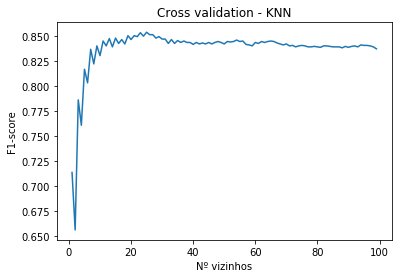

O melhor lambda é 25, com F1-score = 0.8537997744940953


In [78]:
cv_knnBalanced = pd.Series(cv_knnBalanced, index = k_list)
cv_knnBalanced.plot(title = "Cross validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnBalanced.idxmax(), cv_knnBalanced.max()))

In [86]:
knnModel = KNeighborsClassifier(n_neighbors=cv_knnBalanced.idxmax())
knnModel.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(knnModel)))

O F1 do modelo para todos os dados é 0.8857255313565994


## Decision tree

In [87]:
depth_list = np.arange(1,100,1).tolist()

In [18]:
cv_treeUnbalanced = [cv_report(DecisionTreeClassifier(max_depth=depth), treino_X, treino_Y, 5).mean()
            for depth in depth_list]

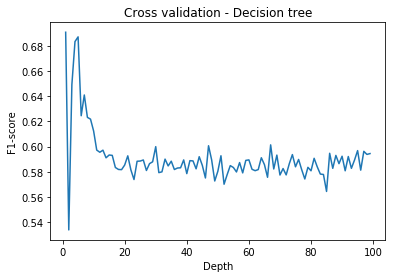

O melhor lambda é 1, com F1-score = 0.6908711885676002


In [19]:
cv_treeUnbalanced = pd.Series(cv_treeUnbalanced, index = depth_list)
cv_treeUnbalanced.plot(title = "Cross validation - Decision tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_treeUnbalanced.idxmax(), cv_treeUnbalanced.max()))

In [88]:
cv_treeBalanced = [cv_report(DecisionTreeClassifier(max_depth=depth), x_cc, y_cc, 5).mean()
            for depth in depth_list]

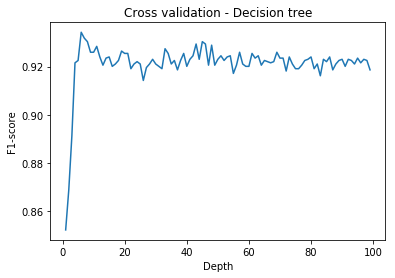

O melhor lambda é 6, com F1-score = 0.9342056851225446


In [89]:
cv_treeBalanced = pd.Series(cv_treeBalanced, index = depth_list)
cv_treeBalanced.plot(title = "Cross validation - Decision tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_treeBalanced.idxmax(), cv_treeBalanced.max()))

In [91]:
decTree = DecisionTreeClassifier(max_depth=cv_treeBalanced.idxmax())
decTree.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(decTree)))

O F1 do modelo para todos os dados é 0.8067436368407243


## Random forest

In [98]:
depth_list = np.arange(1,100,1).tolist()

cv_forest = [cv_report(RandomForestClassifier(max_depth = max_depth, n_estimators=70, random_state=7), x_cc, y_cc, 5).mean()
            for max_depth in depth_list]

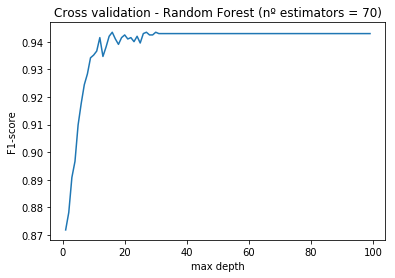

A melhor profundidade (para estimators=100) é 16, com F1 = 0.9434585484540976


In [99]:
cv_forest = pd.Series(cv_forest, index = depth_list)
cv_forest.plot(title = "Cross validation - Random Forest (nº estimators = 70)")
plt.xlabel("max depth")
plt.ylabel("F1-score")
plt.show()

print("A melhor profundidade (para estimators=70) é {0}, com F1 = {1}".format(cv_forest.idxmax(), cv_forest.max()))

In [100]:
estimators_list = np.arange(10,500,10).tolist()

cv_forest_dpMin = [f1_cv(RandomForestClassifier(max_depth = cv_forest.idxmax(), n_estimators = n_estimators, random_state=7), x_cc, y_cc, 5).mean()
            for n_estimators in estimators_list]

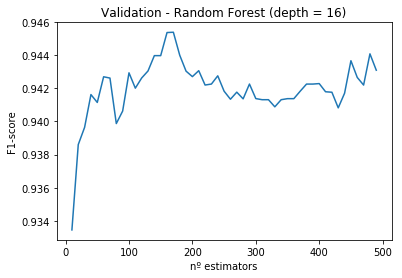

O melhor número de estimators (para profundidade=16) é 170, com F1 = 0.9453795023820757


In [101]:
cv_forest_dpMin = pd.Series(cv_forest_dpMin, index = estimators_list)
cv_forest_dpMin.plot(title = "Validation - Random Forest (depth = {0})".format(cv_forest.idxmax()))
plt.xlabel("nº estimators")
plt.ylabel("F1-score")
plt.show()

print("O melhor número de estimators (para profundidade={0}) é {1}, com F1 = {2}".format(cv_forest.idxmax(), cv_forest_dpMin.idxmax(), cv_forest_dpMin.max()))

In [102]:
rdForest = RandomForestClassifier(max_depth=cv_forest.idxmax(), n_estimators=cv_forest_dpMin.idxmax(), random_state=7)
rdForest.fit(x_cc,y_cc)

print("O F1 do modelo para todos os dados é {0}".format(real_f1(rdForest)))

O F1 do modelo para todos os dados é 0.8588297034898976


## Adaboost

In [ ]:
estimators = np.arange(1,50,1).tolist()
cv_adaBoost =  [f1_cv(AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1), algorithm="SAMME", 
                                    n_estimators=estimator)).mean() 
            for estimator in estimators]
cv_adaBoost = pd.Series(cv_adaBoost, index = estimators)

#plot do AUC-Precision&Recall na validação cruzada
cv_ada.plot(title = "Cross validation - Adaboost")
plt.xlabel("Estimator")
plt.ylabel("F1-score")
print("A quantidade de árvores ideal é {0}, com F1 = {1}".format(cv_ada.idxmax(), cv_ada.max()))

## Dados de envio

In [104]:
lgModel = LogisticRegression(solver="lbfgs", max_iter=10000, C=cv_logRegBalanced.idxmax(), random_state=1)
lgModel.fit(x_cc,y_cc)


predictions = lgModel.predict(teste)

In [61]:
rdForest = RandomForestClassifier(max_depth=26, n_estimators=100, random_state=7)
rdForest.fit(x_cc,y_cc)

predictions = rdForest.predict(teste)

In [105]:
envio = pd.read_csv("sample_submission.csv")

envio["Predicted"] = predictions
envio["Predicted"] = envio["Predicted"].replace([0, 1],['nao_eleito', 'eleito'])

In [106]:
envio.to_csv("Envio.csv")